## News Topic Classification

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

f:\Developershub-Corporation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load AG News dataset
dataset = load_dataset("ag_news")


In [3]:
# Convert to Pandas DataFrame for EDA
train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])

In [4]:
train_df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [5]:
print(f"X_train shape: {train_df.shape}, X_test shape: {test_df['label'].shape}")

X_train shape: (120000, 2), X_test shape: (7600,)


In [6]:
# Check class distribution
print("Class distribution:\n", train_df["label"].value_counts(normalize=True))

Class distribution:
 label
2    0.25
3    0.25
1    0.25
0    0.25
Name: proportion, dtype: float64


### Exploratory Data Analysis

In [7]:
# Checking null values
print("Null values in train set:\n", train_df.isnull().sum())

Null values in train set:
 text     0
label    0
dtype: int64


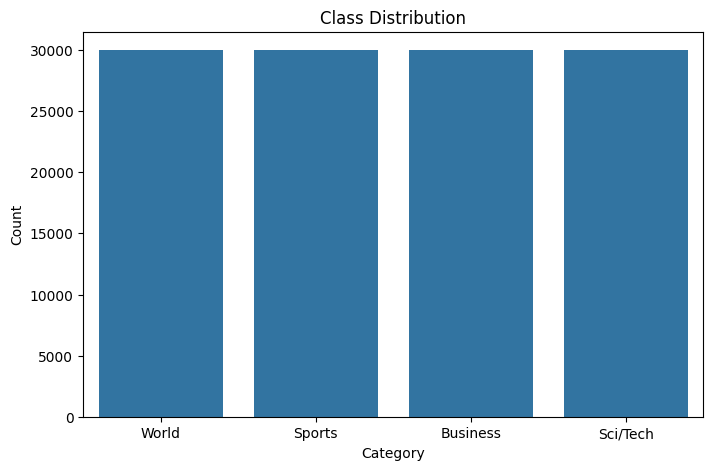

In [8]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x="label", data=train_df)
plt.title("Class Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks([0, 1, 2, 3], ["World", "Sports", "Business", "Sci/Tech"])
plt.show()

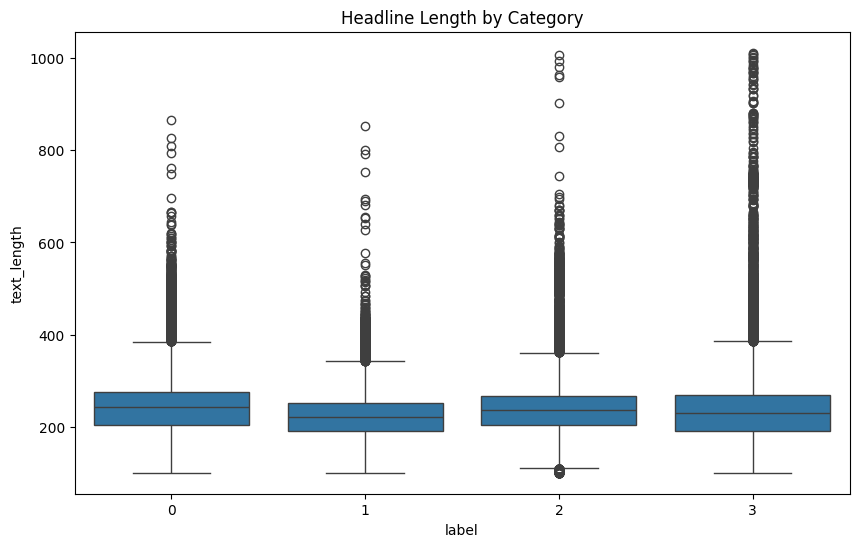

In [9]:
# Visualize headline length by category
train_df["text_length"] = train_df["text"].apply(len)
plt.figure(figsize=(10, 6))
sns.boxplot(x="label", y="text_length", data=train_df)
plt.title("Headline Length by Category")
plt.show()

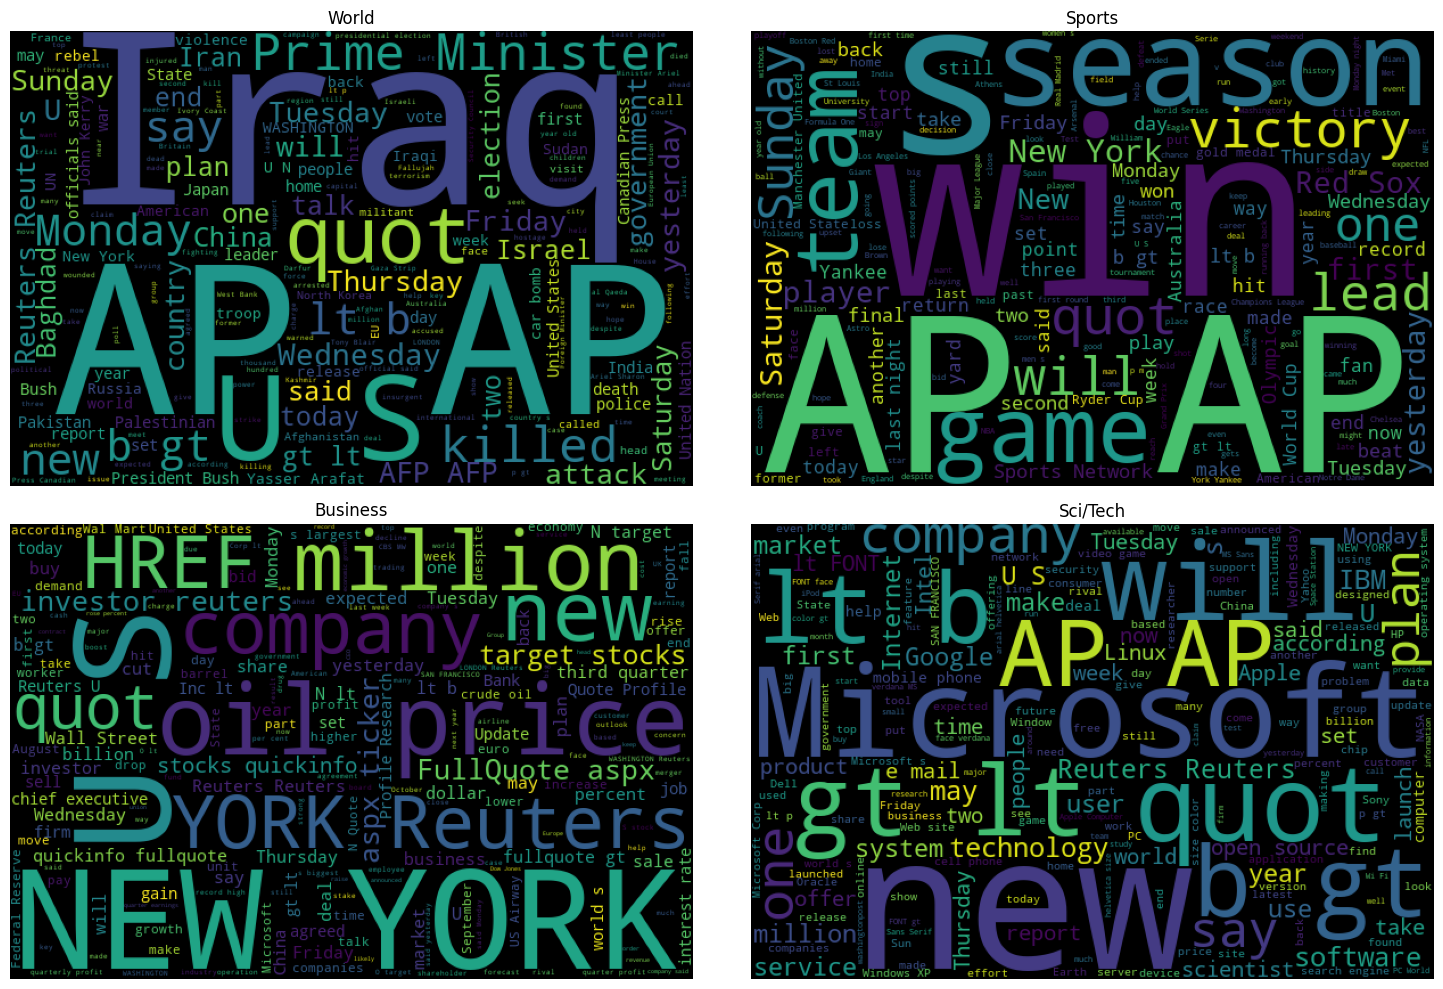

In [10]:
# Visualize word clouds for each category

from wordcloud import WordCloud

categories = ["World", "Sports", "Business", "Sci/Tech"]
plt.figure(figsize=(15, 10))
for i, category in enumerate(categories):
    text = " ".join(train_df[train_df["label"] == i]["text"])
    wordcloud = WordCloud(width=600, height=400).generate(text)
    plt.subplot(2, 2, i+1)
    plt.imshow(wordcloud)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Data Cleaning and pre-processing

In [11]:
# Download NLTK resources using ( pip install nltk ) on terminal
import re
import string
from nltk.corpus import stopwords
import nltk

In [12]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\Rafy
[nltk_data]     Mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
train_df['text'][0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [14]:
# since the text is in English but it has some non-English characters, we will use the English stopwords

In [15]:
# Function to clean text data
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Remove special chars
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

In [16]:
train_df["cleaned_text"] = train_df["text"].apply(clean_text)
test_df["cleaned_text"] = test_df["text"].apply(clean_text)

In [17]:
train_df['cleaned_text'][0]

'wall st bears claw back black reuters reuters shortsellers wall streets dwindlingband ultracynics seeing green'

In [18]:
# Add word count, unique words, etc.
train_df["word_count"] = train_df["cleaned_text"].apply(lambda x: len(x.split()))


In [19]:
test_df["word_count"] = test_df["cleaned_text"].apply(lambda x: len(x.split()))

In [20]:
train_df.head(3)

,text,label,text_length,cleaned_text,word_count
0,Wall St. Bears Claw Back Into the Black (Reute...,2,144,wall st bears claw back black reuters reuters ...,15
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,266,carlyle looks toward commercial aerospace reut...,25
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,232,oil economy cloud stocks outlook reuters reute...,24


In [21]:
test_df.head(3)

,text,label,cleaned_text,word_count
0,Fears for T N pension after talks Unions repre...,2,fears n pension talks unions representing work...,17
1,The Race is On: Second Private Team Sets Launc...,3,race second private team sets launch date huma...,32
2,Ky. Company Wins Grant to Study Peptides (AP) ...,3,ky company wins grant study peptides ap ap com...,27


### Model Training (BERT FINE TUNING)

In [22]:
# Tokenization

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

Map: 100%|██████████| 7600/7600 [00:01<00:00, 4380.53 examples/s]


### Fine-Tuning Bert

In [25]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

training_args = TrainingArguments(
    output_dir="./bert-agnews",
    eval_strategy="epoch",  # Changed from evaluation_strategy to eval_strategy
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
f:\Developershub-Corporation\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 